In [ ]:
import nltk
from nltk.corpus import treebank
import pandas as pd
import numpy as np
import os
from numba import jit

# Hidden Markov Model
|||
|---|---|
| $Q=q_1q_2\dots q_N$ | a set of N states|
| $A=a_{11}\dots a_{ij}\dots a_{NN}$ | a transition probability matrix $A$, each $a_{ij}$ representing the probability of moving from state $i$ to state $j$, s.t. $\sum_{j=1}^N a_{ij} = 1 \ \forall i$|
| $B=b_i(o_t)$ | a sequence of observation likelihoods, also called emission probabilities, each expressing the probability of an observation $o_t$ (drawn from a vocabulary $V = v_1, v_2, \dots, v_V$) being generated from a state $q_i$|
|$\pi = \pi_1, \pi_2, \dots, \pi_N$| an initial probability distribution over states. $\pi_i$ is the probability that the Markov chain will start in state $i$. Some states $j$ may have $\pi_j = 0$, meaning that they cannot be initial states. Also, $\sum_{i=1}^N \pi_i = 1$|



# Task 1: To calculate prior probabilities

<!-- Probability of next tag being $tag_i$ given the current tag is $tag_j$
$$
    \text{Transition probability matrix} \rightarrow P(\text{tag}_i\ | \text{tag}_j) \\
$$

Probability of observing word $o_i$ given the hidden state i.e the tag is $tag_j$ -->

In [ ]:
word_and_tag = list(treebank.tagged_words()) # list of tuples : [(<WORD> , <TAG>),...]
words = list(set(treebank.words())) # unique list of words
# pos_tags = [ # from official site but doesn't include error tags like -NONE- , -LRB-, etc.
    # 'CC','CD','DT','EX','FW','IN','JJ','JJR','JJS','LS','MD','NN','NNS','NNP','NNPS','PDT','POS','PRP','PRP$','RB','RBR','RBS','RP','SYM','TO','UH','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WP$','WRB'
# ]
pos_tags = list(set(pair[1] for pair in treebank.tagged_words())) # extract all unique tags from corpus

@jit
def make_sparse_matrix(word_tag_pairs,words,pos_tags):
    """ Make a sparse matrix of word v/s tag counting number of such (<WORD> , <TAG>) tuples in the corpus

    Args:
        word_tag_pairs (List[(str,str)]): List of (<WORD>,<TAG>) tuples
        words (List[str]): List of all unique words. The index in this list will be later used for learning.
        pos_tags (List[str]): List of all unique POS tags occuring in corpus. Likewise, index will be

    Returns:
        _type_: _description_
    """
    sparse_matrix = np.zeros((len(words),len(pos_tags)))
    for word, tag in word_tag_pairs:
        sparse_matrix[words.index(word),pos_tags.index(tag)] += 1
    return sparse_matrix

In [ ]:
bnm = True # True if reconstruct the matrix
if not os.path.exists('./sparse_matrix.csv') or bnm:
    df = pd.DataFrame(
        data = make_sparse_matrix(word_tag_pairs = word_and_tag, words = words, pos_tags = pos_tags),
        columns = pos_tags,
        dtype = np.int32
    )
    df.insert(0,'Words',words)
    df.to_csv('sparse_matrix.csv',index=False)
else :
    df = pd.read_csv('sparse_matrix.csv')
df

,Words,VB,.,JJR,CC,-NONE-,JJS,RBS,EX,-LRB-,...,WRB,UH,TO,",",WP,IN,JJ,LS,NNPS,RP
0,Gerhard,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,expand,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,repeatedly,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,priciest,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,warrants,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12403,313,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12404,excesses,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12405,IRS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12406,*-66,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# For each pos tag top five words
top_words = pd.DataFrame(columns=pos_tags,index=range(5))
for col in pos_tags:
    top_words[col] = df.loc[df[col].nlargest().index,'Words'].values
top_words.T

,0,1,2,3,4
VB,be,have,make,buy,take
.,.,?,!,Gerhard,expand
JJR,more,higher,earlier,lower,less
CC,and,or,But,but,&
-NONE-,*-1,0,*,*T*-1,*U*
JJS,most,largest,least,latest,best
RBS,most,Most,Gerhard,expand,repeatedly
EX,there,There,Gerhard,expand,repeatedly
-LRB-,-LRB-,-LCB-,Gerhard,expand,repeatedly
:,--,;,:,...,-


In [ ]:
def make_transition_matrix_and_initial_probs(tagged_sentences,pos_tags):
    transition_matrix = np.zeros((len(pos_tags),len(pos_tags)),dtype=np.float64)
    initial_probs = np.zeros(len(pos_tags),dtype=np.float64)
    for sentence in tagged_sentences:
        initial_probs[pos_tags.index(sentence[0][1])] += 1
        for n in range(len(sentence)-1):
            tagi = sentence[n][1]
            tagj = sentence[n+1][1]
            transition_matrix[pos_tags.index(tagi),pos_tags.index(tagj)] += 1
    transition_matrix /= np.sum(transition_matrix,axis=1).reshape(-1,1)
    initial_probs /= np.sum(initial_probs)
    return transition_matrix, initial_probs

In [ ]:
A, Pi = make_transition_matrix_and_initial_probs(treebank.tagged_sents(), pos_tags)

print("Transition probability matrix :\n",A)
print("Initial state probability :\n",Pi)

Transition probability matrix :
 [[0.00117463 0.01527016 0.0082224  ... 0.         0.00078309 0.02270948]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00262467 0.0656168  0.         ... 0.         0.         0.        ]
 ...
 [0.         0.38461538 0.         ... 0.         0.         0.        ]
 [0.         0.08368201 0.         ... 0.         0.0083682  0.        ]
 [0.         0.02777778 0.00925926 ... 0.         0.         0.        ]]
Initial state probability :
 [0.00076648 0.         0.00306592 0.05135411 0.02095043 0.00153296
 0.00051099 0.00434338 0.00178845 0.00281042 0.0444558  0.07562596
 0.19775166 0.         0.         0.         0.00025549 0.
 0.00127747 0.00051099 0.00229944 0.         0.04471129 0.04675524
 0.00434338 0.0074093  0.00076648 0.00025549 0.00843127 0.00178845
 0.         0.00025549 0.         0.06259581 0.23122126 0.00076648
 0.00638733 0.00025549 0.00127747 0.         0.0035769  0.12902402
 0.03653551 0.00178845 0.00255493

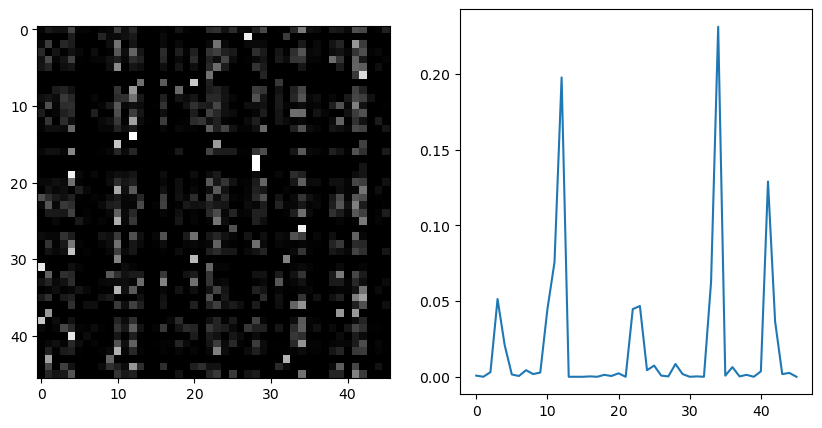

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(np.log(1+A)**0.6,cmap='gray') # log and gamma transform for fun!
plt.subplot(122)
plt.plot(range(len(Pi)),Pi)
plt.show()

In [ ]:
B = df.iloc[:,1:].values.astype(np.float64).T
B /= np.sum(B,axis=1).reshape(-1,1)
print("Emission probability :\n",B)

Emission probability :
 [[0.         0.00195771 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


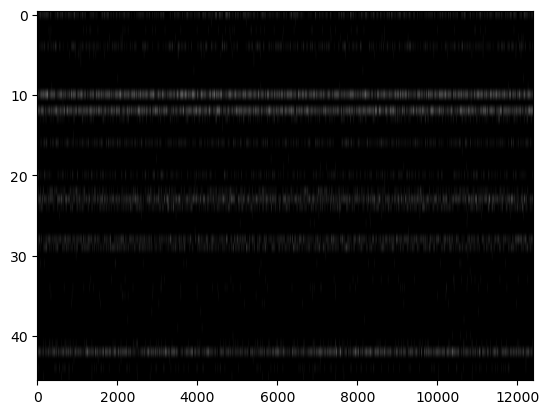

In [ ]:
plt.imshow(np.log(1+B)**0.01,aspect='auto',cmap='gray')

# Viterbi parameters
|||
|---|---|
 |$v_{t-1}(i)$ | the previous Viterbi path probability from the previous time step|
 |$a_{ij}$ | the transition probability from previous state $q_i$ to current state $q_j$|
 |$b_j(o_t)$| the state observation likelihood of the observation symbol ot given the current state $j$|

In [ ]:
from viterbi import viterbi_log

r = 203
test_sent = treebank.sents()[r]
O = [words.index(word) for word in test_sent]
test_tagged = [tag for _, tag in treebank.tagged_sents()[r]]
correct_tag_seq = [pos_tags.index(pair[1]) for pair in treebank.tagged_sents()[r]]

opt_state_seq, log_prob_trellis, backtrack_matrix = viterbi_log(A,Pi,B,O)

print('Observation sequence:   O  = ', O)
print('Optimal state sequence: S  = ', opt_state_seq)
print('Correct state sequence: S* = ', correct_tag_seq)
print("Do they match : ", correct_tag_seq==list(opt_state_seq))

guessed_tags = [pos_tags[i] for i in opt_state_seq]
test_result_df = pd.DataFrame(index=test_sent,columns=['Correct','Guessed'],data=zip(test_tagged,guessed_tags)).T
print('The sentence : ', test_sent)
test_result_df.iloc[:,(test_result_df.nunique()!=1).values]

Observation sequence:   O  =  [3167, 3124, 4132, 4131, 8598, 9436, 1467, 4131, 7699, 872, 4122, 1746, 4342, 4547, 1826, 7356, 2590, 2014, 544, 4131, 6835, 10923, 5163, 4363]
Optimal state sequence: S  =  [12 12 12 39 28 23 42 39 16 29  4 42 10 10 10  3 42 10 10 39 34 42 23  1]
Correct state sequence: S* =  [12, 12, 12, 39, 28, 23, 42, 39, 16, 29, 4, 42, 10, 10, 10, 3, 10, 24, 10, 39, 34, 42, 23, 1]
Do they match :  False
The sentence :  ['John', 'R.', 'Stevens', ',', '49', 'years', 'old', ',', 'was', 'named', '*-27', 'senior', 'executive', 'vice', 'president', 'and', 'chief', 'operating', 'officer', ',', 'both', 'new', 'positions', '.']


,chief,operating
Correct,NN,VBG
Guessed,JJ,NN
